In [30]:
import tensorflow as tf
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Subtract, Add, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.constraints import maxnorm
from sklearn.linear_model import Lasso
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn import preprocessing


data = pd.read_excel("C:/Users/ERIC/Desktop/PML-06MTP-115/06MTP 01012020.xlsm", 1)

# Training dataset
x = data.iloc[:, [1,11,35,59]].values
y = data.iloc[:, 83].values

#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0) #try random_state = 42

#Standarization of the data
'''
sc = StandardScaler()
std_x_train = sc.fit_transform(x_train)
std_x_test = sc.fit_transform(x_test)
'''
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

def create_model():
    input_tensor = Input(shape=(x.shape[1],))
    layer_in_drop = Dropout(0.3)

    hidden_layer = Dense(100, activation = 'relu', kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(input_tensor) #Regularize the wieghts to have better accuracy
    layer_drop = Dropout(0.5)

    hidden_layer1 = Dense(100, activation = 'relu',kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer) #Regularize the wieghts to have better accuracy
    layer_drop1 = Dropout(0.5)
    
    hidden_layer2 = Dense(50, activation = 'relu',kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer1) #Regularize the wieghts to have better accuracy
    layer_drop2 = Dropout(0.5)
    
    hidden_layer3 = Dense(50, activation = 'relu',kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer2) #Regularize the wieghts to have better accuracy
    layer_drop3 = Dropout(0.5)

    hidden_layer4 = Dense(25, activation = 'relu', kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer3) #Regularize the wieghts to have better accuracy
    layer_drop4 = Dropout(0.5)
    
    output_tensor = Dense(1)(hidden_layer4)

    model = Model(input_tensor, output_tensor)
    model.compile(optimizer= Adam(0.003),  loss='mean_absolute_error', metrics = ['mean_absolute_error'])
    return model

n_split=3
 
for train_index,test_index in KFold(n_split).split(x):
    x_train,x_test=x[train_index],x[test_index]
    y_train,y_test=y[train_index],y[test_index]
    model= create_model()
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto', 
                        restore_best_weights = True)
    history = model.fit(x_train,
          y_train,
          #validation_data = (x_test, y_test),
          callbacks = [monitor],
          epochs=200,
          batch_size = 3,
          validation_split = 0.2,
          verbose=0)
    print('Model evaluation ',model.evaluate(x_test,y_test))

Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
29/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 13ms/sample - loss: 80.6433 - mean

In [31]:
from sklearn.metrics import r2_score
pred = model.predict(x_test)
score = np.sqrt(mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
pred_train = model.predict(x_train)
print("R^2 on training set is {}".format(r2_score(y_train, pred_train)))
print("R^2 on testing set is {}".format(r2_score(y_test, pred)))

pred = pd.DataFrame(pred)
pred.columns = ['Prediction']
y_test = pd.DataFrame(y_test)
y_test.columns = ['Real Value']
results = pd.concat([pred,y_test], axis =1)
results


Final score (RMSE): 86.13305200659597
R^2 on training set is -0.1309507987063323
R^2 on testing set is -0.12135463069074537


,Prediction,Real Value
0,331.190979,305.72
1,304.142517,259.68
2,237.878357,111.46
3,209.911469,332.61
4,324.239288,415.79
5,352.539490,342.00
6,327.003204,288.16
7,326.177368,281.92
8,306.246429,296.18
9,247.916443,287.91


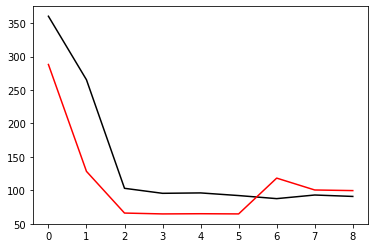

In [32]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.figure()
plt.plot(loss_values, 'k', label = 'training_loss')
plt.plot(val_loss_values, 'r', label = 'val training loss')